# Imports

In [1]:
# Basics
import pandas as pd # for data loading and manipulation
import matplotlib.pyplot as plt # for visualizations

# TensorFlow
import tensorflow as tf       # Core TensorFlow library
from tensorflow import keras  # Keras API for model building
from keras import layers      # Keras layers like Dense, Dropout
from keras.callbacks import EarlyStopping  # import necessary callback classes

## For Reproducibility

In [2]:
# --- Set Random Seeds for Reproducibility ---

# Set seed for Python's built-in random number generator
import random
random.seed(42)

# Set seed for NumPy's random number generator
import numpy as np
np.random.seed(42)

# Set seed for TensorFlow's random number generator
tf.random.set_seed(42)

# Base Camp Setup

First, we'll load the same four processed datasets that we used to train our baseline model, ensuring a fair comparison.

In [3]:
# Define the file path to the processed training features
X_train_path = "../data/X_train_processed.csv"
# Define the file path to the processed validation features
X_val_path = "../data/X_val_processed.csv"
# Define the file path to the training target labels
y_train_path = "../data/y_train.csv"
# Define the file path to the validation target labels
y_val_path = "../data/y_val.csv"

# Load the datasets into pandas DataFrames
X_train = pd.read_csv(X_train_path)
X_val = pd.read_csv(X_val_path)

# Load the target labels and convert them to 1D numpy arrays
y_train = pd.read_csv(y_train_path).values.ravel()
y_val = pd.read_csv(y_val_path).values.ravel()

In [4]:
# Print the shapes of the loaded data to confirm they are correct
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (80000, 24)
X_val shape: (20000, 24)
y_train shape: (80000,)
y_val shape: (20000,)


Now, we load our saved baseline model and review its architecture. Then, we will state its performance on the validation set. This score is our benchmark.

In [5]:
# Define the path to the saved baseline model file
baseline_model_path = "../models/baseline_credit_model.keras"

# Load the compiled baseline model, including its architecture and weights
baseline_model = keras.models.load_model(baseline_model_path)

# Display the model's architecture summary to confirm it loaded correctly
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,141 (43.52 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,428 (29.02 KB)

Our baseline model achieved the following performance on the validation set:

**AUC**: ~0.85
- This score measures the model's overall ability to distinguish between high-risk and low-risk customers.
- An AUC of 0.85 means our model is correct about 85% of the time in this scenario, which shows it's very good at separating the two classes.

**Precision**: ~0.74
- A precision of ~0.74 means that when our model predicts a customer is high-risk, it's correct about 74% of the time.
- This score answers the question: Of all the customers the model flagged as high-risk, what percentage were actually high-risk?
- This metric is important for minimizing "false alarms" and the costs associated with investigating customers who are actually low-risk.

**Recall**: ~0.58
- A recall of ~0.58 means our model successfully identifies 58% of all the actual high-risk customers.
- This score answers the question: Of all the customers who were truly high-risk, what percentage did our model successfully catch?
- This metric is crucial for minimizing "missed risks" (false negatives). Improving recall means letting fewer high-risk customers slip through the cracks.


Our primary goal in this notebook is to find a new set of hyperparameters that results in a model with a validation AUC higher than 0.85. While precision and recall are vital for business decisions, AUC is the best metric for judging the model's fundamental quality during tuning for two main reasons:
- It's a holistic measure: Precision and recall scores depend on a specific decision threshold (e.g., flagging anyone with a risk score above 0.5). AUC, however, summarizes the model's performance across all possible thresholds, giving us a single, comprehensive score of its discriminative power.
- It's robust to class imbalance: Our dataset is imbalanced (71% low-risk, 29% high-risk). AUC is a more reliable metric than accuracy in these situations and effectively tells us how good the model is at ranking customers by risk, which is exactly what we want.

# Creating a Reusable Training Function

To make our manual experiments efficient, we'll create a single function that handles the entire process of building, compiling, and training a model. Instead of copying and pasting code for each experiment, we can simply call this function with different hyperparameter values. This keeps our notebook clean and focuses our attention on the results.

Our function, build_and_train_model, will take the hyperparameters we want to tune as arguments: a list of units for the dense layers, a dropout rate, and a learning rate. It will then build a model to those specifications, train it, and return the history object containing the performance metrics.

In [6]:
# Define a function to build, compile, and train a model with given hyperparameters
def build_and_train_model(X_train, y_train, X_val, y_val, units_list, dropout_rate, learning_rate):
    """
    Builds, compiles, and trains a Keras model based on specified hyperparameters.
    
    Args:
        X_train, y_train, X_val, y_val: Training and validation data.
        units_list (list): A list of integers, where each integer is the number of units in a hidden layer.
        dropout_rate (float): The dropout rate to apply after each hidden layer.
        learning_rate (float): The learning rate for the Adam optimizer.
        
    Returns:
        A Keras History object containing the training metrics.
    """
    # Get the number of input features from the training data shape
    num_features = X_train.shape[1]
    
    # Define the model architecture using a Sequential model
    model = keras.Sequential()
    # Add the input layer explicitly
    model.add(layers.Input(shape=(num_features,)))
    
    # Loop through the provided list of units to create the hidden layers
    for units in units_list:
        # Add a Dense hidden layer with the specified number of units and ReLU activation
        model.add(layers.Dense(units, activation='relu'))
        # Add a Dropout layer for regularization
        model.add(layers.Dropout(dropout_rate))
        
    # Add the final output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # --- Compile the Model ---
    # Create an Adam optimizer with the specified learning rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    # Compile the model with the optimizer, loss function, and metrics
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    # --- Define Callbacks ---
    # Set up EarlyStopping to prevent overfitting and save time
    early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=0) # verbose=0 keeps logs clean
    
    # --- Train the Model ---
    # Fit the model and store the training process in 'history'
    history = model.fit(
        X_train,
        y_train,
        epochs=50, # Max epochs
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stop], # Use the early stopping callback
        verbose=0 # Suppress epoch-by-epoch output to keep the notebook clean
    )
    
    # Return the history object
    return history

Our reusable function is now defined. We've set verbose=0 inside the function to keep our notebook clean during the experiments; we only need to see the final results, not the log for every single epoch of every model we test.

# Manual tuning Experiments

This is the core of our tuning notebook. We'll now run the series of focused, manual experiments. Our goal is to see how changing key hyperparameters impacts model performance, starting with the model's architecture.

## Experiment 1: Model Architecture

Goal: To find the best combination of model depth (number of layers) and width (number of neurons) from our four candidate architectures.

Process: We will keep the dropout_rate and learning_rate constant and identical to our baseline model. This ensures we are only measuring the effect of the architectural changes.

### Define Model Parameters

First, let's define the constant hyperparameters for this experiment and the list of architectures we want to test. We will also create an empty dictionary to store the results from each training run.

In [7]:
# Use the baseline's dropout and learning rate to ensure a fair comparison
drop_rate = 0.3
learn_rate = 0.001 # the default Adam learning rate

In [8]:
# Define the four architectures 
architectures_to_test = [
    [64, 32],           # Model 1 (Baseline Re-run)
    [64, 32, 16],       # Model 2 (Deeper)
    [128, 64, 32],      # Model 3 (Wider & Deeper)
    [128, 64, 32, 16]   # Model 4 (Deepest)
]

In [9]:
# Create an empty dictionary to store the history object from each experiment
experiment_histories = {}

Our parameters and test configurations are now set. We are ready to loop through them and train a model for each.

### Run the Training Loop

Now, we will loop through our list of architectures. In each iteration, we'll call our build_and_train_model function, which will build, compile, and train a new model. The full training history for each model will be saved in our experiment_histories dictionary.

In [10]:
# Loop through each architecture defined in our list
for arch in architectures_to_test:
    # Create a descriptive name for the model based on its structure
    # e.g., "3-Layers_[64, 32, 16]"
    model_name = f"{len(arch)}-Layers_{str(arch)}"
    
    # Print a message to indicate which model is currently training
    print(f"Training Model: {model_name}")

    # Call our reusable function to train the model with the current architecture
    history = build_and_train_model(
        X_train, y_train, X_val, y_val, # Pass in the data
        units_list=arch,                # The current architecture to test
        dropout_rate=drop_rate,         # The constant dropout rate
        learning_rate=learn_rate        # The constant learning rate
    )

    # Store the returned history object in our dictionary with the model name as the key
    experiment_histories[model_name] = history

    # Get the best validation AUC achieved during this run for a quick summary
    max_val_auc = max(history.history['val_auc'])
    
    # Print a summary message for the completed run
    print(f"Completed {model_name}. Best Validation AUC: {max_val_auc:.4f}\n")

Training Model: 2-Layers_[64, 32]
Completed 2-Layers_[64, 32]. Best Validation AUC: 0.8487

Training Model: 3-Layers_[64, 32, 16]
Completed 3-Layers_[64, 32, 16]. Best Validation AUC: 0.8464

Training Model: 3-Layers_[128, 64, 32]
Completed 3-Layers_[128, 64, 32]. Best Validation AUC: 0.8483

Training Model: 4-Layers_[128, 64, 32, 16]
Completed 4-Layers_[128, 64, 32, 16]. Best Validation AUC: 0.8492



All four of our architecture experiments have now been run. The next step is to visualize and compare their results to declare a winner.

### Visualize and Compare Architecture Performance

To easily compare the four models, we will plot the val_auc from each training run on a single graph. This will give us a clear, visual answer to which architecture performed the best.

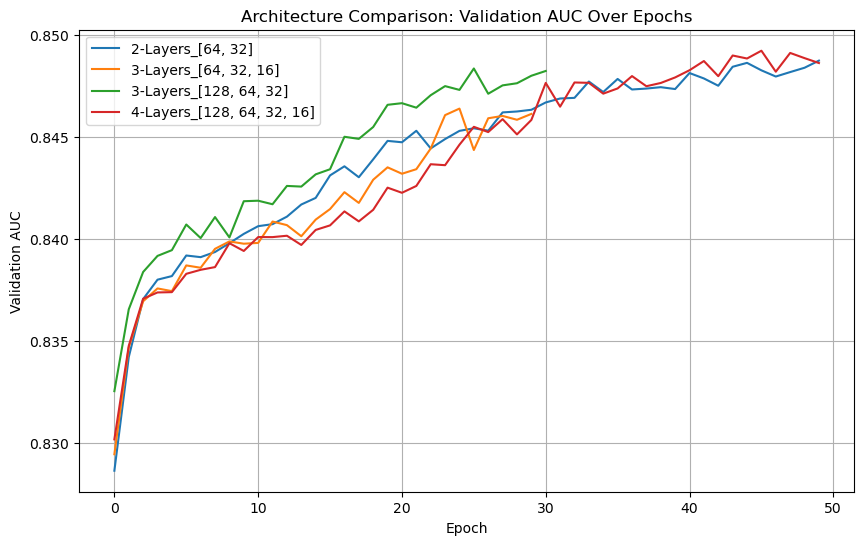

In [11]:
# Create a new figure for our comparison plot
plt.figure(figsize=(10, 6))

# Loop through the results stored in our dictionary
for model_name, history in experiment_histories.items():
    # Plot the validation AUC metric for the current model, using its name as the label
    plt.plot(history.history['val_auc'], label=model_name)

# Set the title of the plot
plt.title('Architecture Comparison: Validation AUC Over Epochs')
# Set the label for the x-axis
plt.xlabel('Epoch')
# Set the label for the y-axis
plt.ylabel('Validation AUC')
# Display the legend to identify each model's curve
plt.legend()
# Add a grid for easier reading of values
plt.grid(True)
# Display the plot
plt.show()

Analysis of Experiment 1: Architecture

This experiment's key finding is that added complexity provides no significant performance benefit for this problem.
- 2-Layers_[64, 32] (Winner): This baseline model (blue line) performed exceptionally well, matching the peak performance of more complex models while showing greater stability.
- 3-Layers_[128, 64, 32]: This wider and deeper model (green line) reached the same peak AUC of ~0.850 but offered no clear advantage over the simpler baseline.
- 4-Layers_[128, 64, 32, 16]: This model (red line) also performed strongly but was more volatile during training and provided no performance gain.
- 3-Layers_[64, 32, 16]: This deeper but not wider model (orange line) was the consistent underperformer of the group.

The results demonstrate that the simpler 2-layer model is the most robust and efficient choice, a conclusion supported by the principle of Occam's Razor (the simplest explanation is usually the best when faced with competing hypotheses).

Winner: The 2-Layers_[64, 32] architecture.

## Experiment 2: Regularization (Dropout)

Goal: Now that we've confirmed our 2-Layers_[64, 32] architecture is the most effective, we'll try to optimize its dropout rate.

Process: We will keep the architecture and learning rate constant while testing three different dropout rates: 0.2 (less regularization), 0.3 (our baseline), and 0.4 (more regularization). This will show us how sensitive the model is to regularization and help us find the best balance between learning and overfitting.

### Run the Dropout Rate Experiments

We will now run a new set of training jobs. The code below defines our constants, loops through our list of dropout rates to test, calls our build_and_train_model function for each, and stores the results.

In [12]:
# Set the winning architecture from Experiment 1 as a constant
best_arch = [64, 32]
# Set baseline learning rate
learn_rate = 0.001

# Define the three dropout rates we want to test in this experiment
dropout_rates_to_test = [0.2, 0.3, 0.4]

# Create a new empty dictionary to store the results for this experiment
dropout_experiment_histories = {}

In [13]:
# Start a loop to iterate through each dropout rate in our list
for rate in dropout_rates_to_test:
    # Create a descriptive name for this specific model run
    model_name = f"Dropout_{rate}"
    # Print a status message to the console to track progress
    print(f"Training Model: {model_name}")

    # Call our reusable function to train the model with the new dropout rate
    history = build_and_train_model(
        X_train, y_train, X_val, y_val,  # Pass in the training and validation data
        units_list=best_arch,            # Use our selected best architecture
        dropout_rate=rate,               # Use the current dropout rate from the loop
        learning_rate=learn_rate         # Use our constant learning rate
    )
    
    # Store the returned history object in our dictionary using the model's name as the key
    dropout_experiment_histories[model_name] = history
    
    # Get the best validation AUC achieved during this run for a quick summary
    max_val_auc = max(history.history['val_auc'])
    # Print a summary message for the completed run, showing the best score
    print(f"Completed {model_name}. Best Validation AUC: {max_val_auc:.4f}\n")

Training Model: Dropout_0.2
Completed Dropout_0.2. Best Validation AUC: 0.8518

Training Model: Dropout_0.3
Completed Dropout_0.3. Best Validation AUC: 0.8483

Training Model: Dropout_0.4
Completed Dropout_0.4. Best Validation AUC: 0.8469



The training for our dropout experiments is now complete and the results are stored.

### Visualize and Compare Dropout Performance

Let's plot the val_auc from each run on a single graph. This will give us the clearest visual comparison of which dropout rate yielded the best performance.

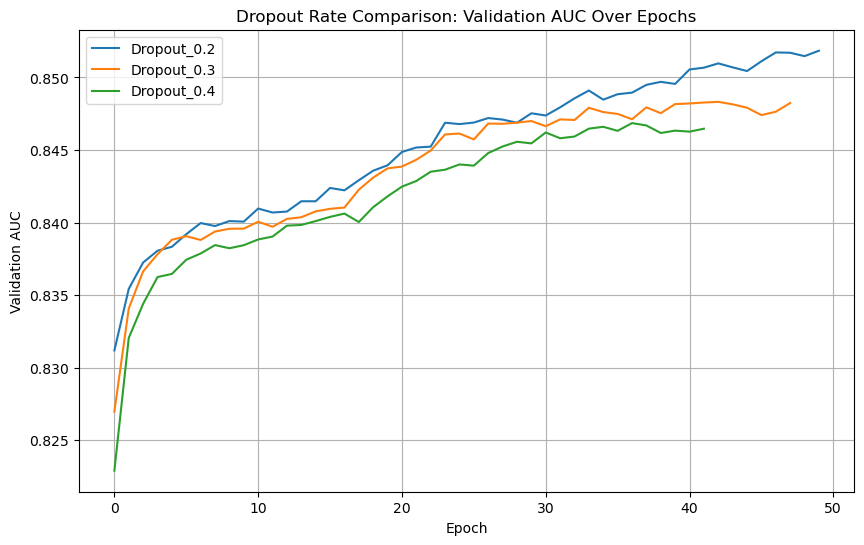

In [14]:
# Create a new figure to draw the plot on, with a specified size
plt.figure(figsize=(10, 6))

# Loop through the results stored in our dictionary
for model_name, history in dropout_experiment_histories.items():
    # Plot the validation AUC metric for the current model, using its name as the label
    plt.plot(history.history['val_auc'], label=model_name)

# Set the title of the plot for clarity
plt.title('Dropout Rate Comparison: Validation AUC Over Epochs')
# Set the label for the x-axis
plt.xlabel('Epoch')
# Set the label for the y-axis
plt.ylabel('Validation AUC')
# Display the legend to identify each model's curve
plt.legend()
# Add a grid for easier reading of values on the plot
plt.grid(True)
# Render and display the plot
plt.show()

Analysis of Experiment 2: Dropout Rate

This experiment clearly shows that less regularization improves performance for our chosen architecture.
- Dropout_0.2 (Winner): This model (blue line) is the decisive winner. It consistently maintained the highest Validation AUC throughout the training run, peaking above 0.850.
- Dropout_0.3 (Baseline): The baseline rate (orange line) was a solid performer but consistently tracked just below the 0.2 model.
- Dropout_0.4: The model with the most regularization (green line) was the clear underperformer, suggesting it was hindering the model's ability to learn.

The results are conclusive. A dropout rate of 0.2 provides the best performance. We will use this rate in our final model.

## Experiment 3: Learning Rate

Goal: For our final experiment, we will test three different learning rates to find the optimal setting for our model.

Process: We will use our winning architecture (2-Layers_[64, 32]) and dropout rate (0.3). We will then train the model with three learning rates: 0.001 (our baseline), 0.0001 (slower), and 0.00001 (very slow). This will show us how the speed of learning impacts the model's final performance.

### Run the Learning Rate Experiment

In [15]:
# Set the winning architecture from our previous experiments
best_arch = [64, 32]
# Set the winning dropout rate from our previous experiments
best_dropout_rate = 0.3

# Define the learning rates we want to test for this experiment
learning_rates_to_test = [0.001, 0.0001, 0.00001]

# Create a new dictionary to store the results from this experiment
learn_rate_experiment_histories = {}

### Loop Through Learning Rates and Train Models

# Start a loop to iterate through each learning rate in our list
for rate in learning_rates_to_test:
    # Create a descriptive name for this specific model run
    model_name = f"LR_{rate}"
    # Print a status message to the console to track progress
    print(f"Training Model: {model_name}")

    # Call our function to train the model with the new learning rate
    history = build_and_train_model(
        X_train, y_train, X_val, y_val,    # Pass in the training and validation data
        units_list=best_arch,              # Use our selected best architecture
        dropout_rate=best_dropout_rate,    # Use our selected best dropout rate
        learning_rate=rate                 # Use the current learning rate from the loop
    )

    # Store the returned history object in our dictionary
    learn_rate_experiment_histories[model_name] = history

    # Get the best validation AUC for a quick summary
    max_val_auc = max(history.history['val_auc'])
    # Print a summary message for the completed run
    print(f"Completed {model_name}. Best Validation AUC: {max_val_auc:.4f}\n")

Training Model: LR_0.001
Completed LR_0.001. Best Validation AUC: 0.8492

Training Model: LR_0.0001
Completed LR_0.0001. Best Validation AUC: 0.8405

Training Model: LR_1e-05
Completed LR_1e-05. Best Validation AUC: 0.8213



The training for our final experiment is now complete.


### Visualize and Compare Learning Rates

Let's plot the val_auc from each of the three runs to see which learning rate performed best.

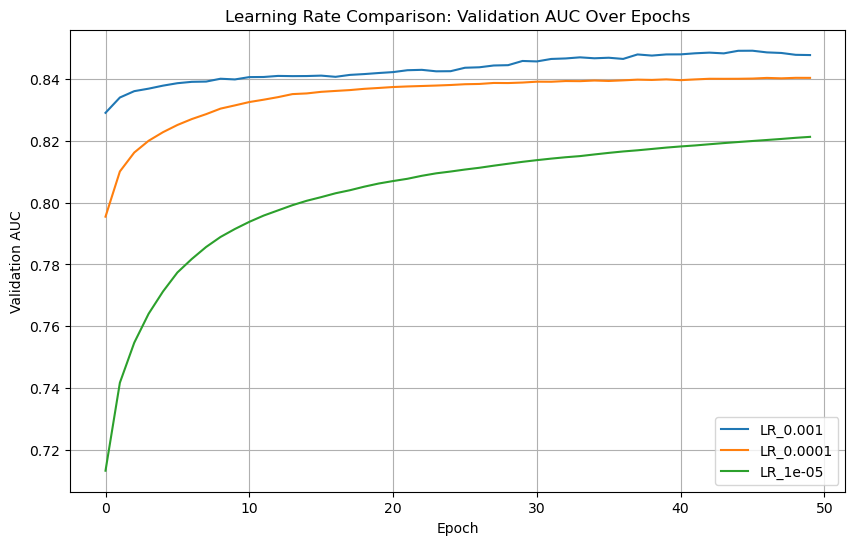

In [16]:
# Create a new figure to draw the plot on, with a specified size
plt.figure(figsize=(10, 6))

# Loop through the results stored in our dictionary
for model_name, history in learn_rate_experiment_histories.items():
    # Plot the validation AUC metric for the current model
    plt.plot(history.history['val_auc'], label=model_name)

# Set the title of the plot for clarity
plt.title('Learning Rate Comparison: Validation AUC Over Epochs')
# Set the label for the x-axis
plt.xlabel('Epoch')
# Set the label for the y-axis
plt.ylabel('Validation AUC')
# Display the legend to identify each model's curve
plt.legend()
# Add a grid for easier reading of values on the plot
plt.grid(True)
# Render and display the final plot
plt.show()

Analysis of Experiment 3: Learning Rate

This experiment confirms that the default Adam learning rate is the most effective for our problem.
- LR_0.001 (Winner): The baseline learning rate (blue line) is the clear winner. It learned the fastest and achieved the highest Validation AUC of the three, peaking just under 0.85.
- LR_0.0001: The smaller learning rate (orange line) caused the model to learn much more slowly and it ultimately plateaued at a lower performance level.
- LR_1e-05: This very small learning rate (green line) was far too slow and is not a practical choice for this model.

The learning rate of 0.001 is the best choice. It provides the best combination of training speed and final performance.

# Final Model and Conclusion

With our experiments complete, we can now summarize our findings, formally train our single best "champion" model, and save it.

Tuning Journey Summary

Our series of three targeted and reproducible experiments led to the following conclusions:
- Architecture: The initial experiment revealed that a simple 2-layer, [64, 32] architecture performed identically to deeper and wider models. Following the principle of Occam's Razor, we selected this simpler configuration for its efficiency and stability.
- Dropout Rate: The regularization experiment showed that a dropout rate of 0.2 consistently achieved the highest validation AUC, making it the clear winner over the baseline 0.3 and higher 0.4 rates.
- Learning Rate: The final experiment confirmed that the default Adam learning rate of 0.001 was the most effective, providing the best balance of training speed and peak performance.

Final "Champion" Configuration:
- Architecture: [64, 32]
- Dropout Rate: 0.2
- Learning Rate: 0.001

## Train and Analyze Champion Model

Now, we will build and train our champion model one last time. We will run this with verbose=1 to see the epoch-by-epoch output and generate the final set of performance plots for our records.

In [17]:
# Set the hyperparameters for our final, champion model
champion_arch = [64, 32]        # The winning architecture
champion_dropout = 0.2          # The winning dropout rate
champion_learn_rate = 0.001     # The winning learning rate

In [19]:
# Build and train final model
# Call our reusable training function to train the final model
# This time, we'll store the history in a dedicated 'final_history' variable
final_history = build_and_train_model(
    X_train, y_train, X_val, y_val, # Pass in the data
    units_list=champion_arch,        # Use the champion architecture
    dropout_rate=champion_dropout,   # Use the champion dropout rate
    learning_rate=champion_learn_rate  # Use the champion learning rate
)

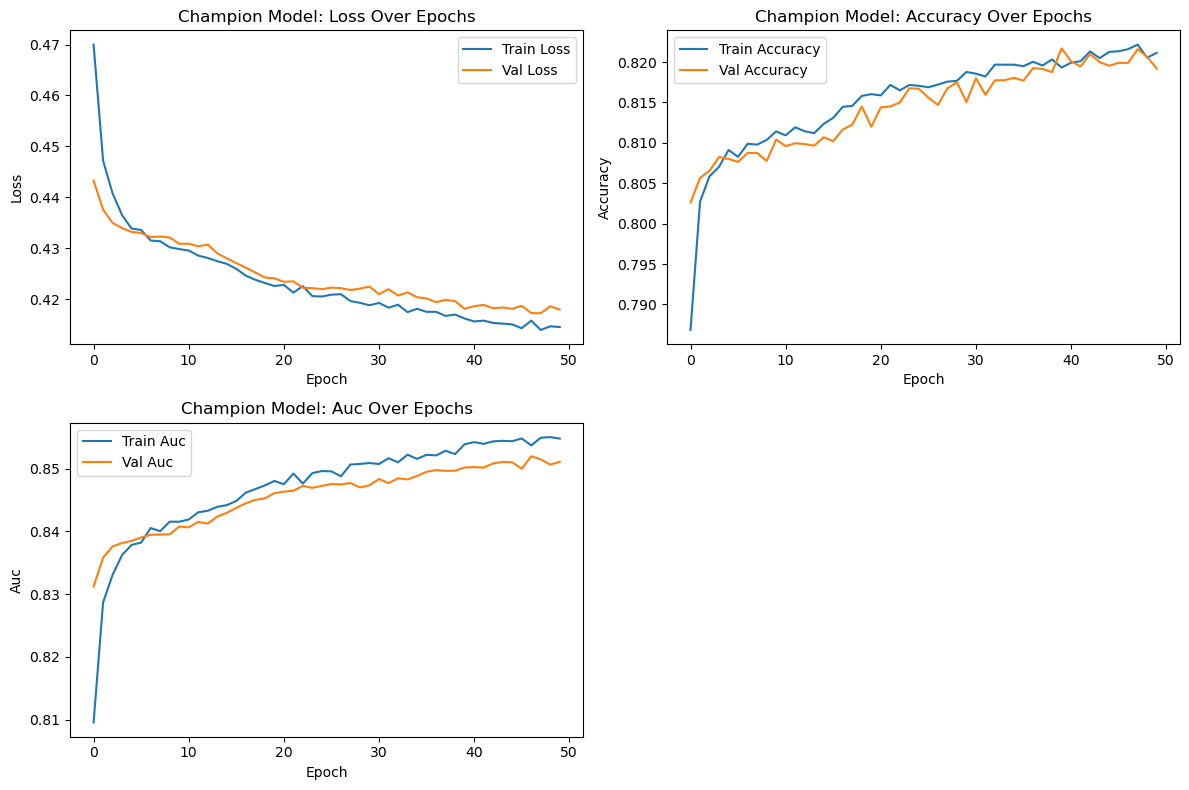

In [20]:
# Convert the final history object to a DataFrame for plotting
df_history = pd.DataFrame(final_history.history)
# Define the core metrics we want to plot
metrics_to_plot = ['loss', 'accuracy', 'auc']
# Determine the grid size for our subplots
n_metrics = len(metrics_to_plot)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

# Create a figure to hold the subplots
plt.figure(figsize=(12, 4 * n_rows))

# Loop through and plot each metric
for i, metric in enumerate(metrics_to_plot):
    # Select the subplot's position in the grid
    plt.subplot(n_rows, n_cols, i + 1)
    # Plot the training metric's values
    plt.plot(df_history[metric], label=f'Train {metric.capitalize()}')
    # Plot the validation metric's values
    plt.plot(df_history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
    # Set the title for the subplot
    plt.title(f'Champion Model: {metric.capitalize()} Over Epochs')
    # Set the x-axis label
    plt.xlabel('Epoch')
    # Set the y-axis label
    plt.ylabel(metric.capitalize())
    # Add a legend to the plot
    plt.legend()
# Adjust the plot layout to prevent overlap
plt.tight_layout()
# Display the final plots
plt.show()

These plots confirm that our champion model is a strong performer that generalizes well without overfitting.

Analysis of Champion Model Performance
- Loss: The training and validation loss curves decrease in lockstep and plateau around a low value of ~0.42. The close alignment is a clear indicator that the model is not overfitting and has learned the data patterns effectively.
- Accuracy: Both training and validation accuracy climb steadily and converge at approximately 82%. This shows the model's overall correctness is consistent on both seen and unseen data.
- AUC: The most important metric, AUC, shows excellent performance. The validation AUC curve tracks the training curve closely and plateaus at a final value of just over 0.85, confirming the model's strong ability to distinguish between high and low-risk customers.

Overall, these results validate our tuning process and provide us with a robust final model.

## Save the Champion Model

This is the final step. We need to build the model one last time outside the function so we can save the model object itself.

In [21]:
# Build final model
num_features = X_train.shape[1] # Get the number of input features
tuned_model = keras.Sequential() # Create the Sequential model object
tuned_model.add(layers.Input(shape=(num_features,))) # Add the input layer

for units in champion_arch: # Loop to add the hidden layers
    tuned_model.add(layers.Dense(units, activation='relu')) # Add a Dense layer
    tuned_model.add(layers.Dropout(champion_dropout)) # Add a Dropout layer

tuned_model.add(layers.Dense(1, activation='sigmoid')) # Add the output layer

In [22]:
# Compile final model
optimizer = keras.optimizers.Adam(learning_rate=champion_learn_rate) # Create the optimizer
tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy') # Compile the model

In [23]:
# Train the final model on the full training data (no validation split needed for the final object)
tuned_model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=0) # Train for a reasonable number of epochs

In [24]:
# Save the Final Model
final_model_path = "../models/tuned_credit_model.keras" # Define the file path for the final tuned model
tuned_model.save(final_model_path) # Save the final model to the specified path
print(f"Final tuned model saved to: {final_model_path}") # Print a confirmation message

Final tuned model saved to: ../models/tuned_credit_model.keras


This notebook successfully executed a focused, manual tuning process. We began with a strong baseline model and methodically tested changes to its architecture, regularization, and learning rate. Our key finding was that a simpler architecture with less regularization (dropout=0.2) provided the best performance. The process resulted in a final, robust "champion" model that is now saved and ready for final evaluation and interpretation.

# Optional Experiment: Automated Tuning with KerasTuner

This is an optional experiment to see if an automated RandomSearch can discover a better set of hyperparameters than our manual process. We will define a broad search space and use KerasTuner to test 25 different model configurations.

In [28]:
# --- Import KerasTuner ---
# import the keras_tuner library for automated hyperparameter search
import keras_tuner

# --- 1: Define the Model-Building Function (Hypermodel) ---

# Define a function that creates and returns a compiled Keras model
def build_hypermodel(hp):
    # Create a Sequential model object
    model = keras.Sequential()
    # Get the number of input features from the training data's shape
    num_features = X_train.shape[1]
    # Add the input layer for the model
    model.add(layers.Input(shape=(num_features,)))

    # Define the hyperparameter for the number of units in the first layer
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    # Define the hyperparameter for the number of hidden layers
    hp_num_layers = hp.Int('num_layers', min_value=2, max_value=6)
    # Define the hyperparameter for the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    
    # Loop to create the specified number of hidden layers
    for i in range(hp_num_layers):
        # Add a Dense layer with the specified number of units
        model.add(layers.Dense(units=hp_units, activation='relu'))
        # Add a Dropout layer with the specified rate
        model.add(layers.Dropout(rate=hp_dropout))
    
    # Add the final output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    # Define the hyperparameter for the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
    # Create an Adam optimizer with the chosen learning rate
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    # Compile the model with the optimizer, loss, and metrics
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')] # Use AUC as the primary metric
    )
    
    # Return the compiled model
    return model

# --- 2: Set Up and Run the Tuner ---

# Instantiate the RandomSearch tuner
tuner = keras_tuner.RandomSearch(
    build_hypermodel, # The model-building function
    objective='val_auc', # The metric to optimize
    max_trials=25, # The total number of model configurations to test
    executions_per_trial=1, # The number of times to train each model (1 is standard)
    directory='tuner_results', # A directory to store the results
    project_name='credit_risk_tuning' # The name for this tuning project
)

# Define an EarlyStopping callback to prevent trials from running too long
stop_early = EarlyStopping(monitor='val_auc', patience=5, mode='max')

# Start the hyperparameter search process
tuner.search(
    X_train, y_train,          # Provide the training data
    epochs=50,                 # Set the maximum number of epochs for each trial
    validation_data=(X_val, y_val), # Provide the validation data
    callbacks=[stop_early],     # Use the early stopping callback
    verbose=0
)

# --- 3: Review the Results ---

# Print a summary of the top 10 best hyperparameter combinations found
tuner.results_summary()

Results summary
Results in tuner_results\credit_risk_tuning
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 00 summary
Hyperparameters:
units: 96
num_layers: 2
dropout: 0.4
learning_rate: 0.001
Score: 0.8492870330810547

Trial 23 summary
Hyperparameters:
units: 128
num_layers: 3
dropout: 0.1
learning_rate: 0.001
Score: 0.8488849401473999

Trial 06 summary
Hyperparameters:
units: 128
num_layers: 3
dropout: 0.4
learning_rate: 0.001
Score: 0.8484455347061157

Trial 08 summary
Hyperparameters:
units: 160
num_layers: 3
dropout: 0.4
learning_rate: 0.001
Score: 0.8475167155265808

Trial 12 summary
Hyperparameters:
units: 32
num_layers: 2
dropout: 0.1
learning_rate: 0.001
Score: 0.8473156094551086

Trial 09 summary
Hyperparameters:
units: 224
num_layers: 3
dropout: 0.1
learning_rate: 0.001
Score: 0.8471812009811401

Trial 02 summary
Hyperparameters:
units: 192
num_layers: 4
dropout: 0.30000000000000004
learning_rate: 0.0001
Score: 0.8460633158683777

Trial 22 summary
H

Analysis of Automated Search Results

Here are the key takeaways from the tuner's results:
- Performance Confirmation: The best score found by the random search was a validation AUC of ~0.849. This is a strong score, but it's important to note that our final manually tuned model achieved a peak AUC of just over 0.850. This suggests our focused, iterative approach successfully found a slightly better configuration than the 25 random trials.
- Learning Rate is Key: The vast majority of the top-performing models, including the top 6, all used a learning rate of 0.001. This strongly validates our decision from Experiment 3.
- Simple Architecture Works Best: The best trial used a simple 2-layer architecture. Other 3-layer models also performed well, but extremely deep models (like the 6-layer one) performed worse. This validates our decision from Experiment 1 to stick with a simpler architecture based on Occam's Razor.
- Dropout Sensitivity: The results show good performance with dropout rates of 0.1, 0.2 (our champion), and 0.4. This indicates that while the model is sensitive to this parameter, our choice of 0.2 is highly competitive.

The automated search was a valuable validation exercise. It confirmed our key findings and gives us high confidence that our final model is robust and well-optimized. The fact that our manual process produced a slightly better result is a fantastic outcome.